# Statistical Plan with Rank Transformation for Reaction Time

In this script, you can find the same analysis with first rank transformation. Here, we will be using already exported pre-processed clean dataset. We also change the multiple comparison's of levels to the non-parametric equivalent of Tukey's test, which is Dunn test.

## Processing Data

We must start with importing necessary libraries, datasets and merging everything into one big set. Where we will start with data cleaning and determination of outliers. 

In [1]:
import numpy as np
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import rankdata
import pandas as pd
import glob
import statistics
import pingouin as pg
import scikit_posthocs as sp
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.anova import AnovaRM
import warnings
warnings.filterwarnings("ignore")

In [2]:
# use a personal style sheet
plt.style.use("./styles/mystyle.mplstyle")

df = pd.read_csv("DF_cleaned.csv")

## Anova Testing (RT)

### Main Anova size of occlusion x SOA
We only take the true values of accuracy for reaction time anova testing. We also do multiple comparison and do posthoc.

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,size_occl,4.244404e+07,1,28,4.244404e+07,46.034277,2.277132e-07,2.277132e-07,0.013176,1.000000
1,soa,9.683683e+06,2,56,4.841842e+06,7.020051,1.903510e-03,3.068488e-03,0.003037,0.875361
2,size_occl * soa,1.048237e+06,2,56,5.241187e+05,1.189846,3.118418e-01,3.045938e-01,0.000330,0.786959


,0.025,0.050,0.100
0.025,1.000000,1.00000,0.002629
0.050,1.000000,1.00000,0.000060
0.100,0.002629,0.00006,1.000000


,few large,many small
few large,1.000000e+00,2.832778e-17
many small,2.832778e-17,1.000000e+00


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x2688683d400>)

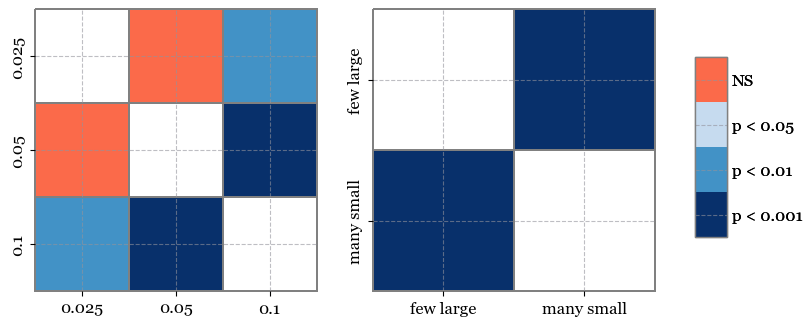

In [3]:
# Main Anova
df_correct =  df[df['acc'] == True]
#ranking the data
df_correct['rt'] =  rankdata(df_correct['rt'])
# Perform Two-Way ANOVA
main_result = pg.rm_anova(data=df_correct, dv='rt', within=['size_occl', 'soa'], subject= 'pt_num', detailed=True)
display(main_result)

#multiple comparisons
posthoc_soa = sp.posthoc_dunn(df_correct, val_col= "rt", group_col= "soa", p_adjust='bonferroni')
display(posthoc_soa)

posthoc_size_occl = sp.posthoc_dunn(df_correct, val_col= "rt", group_col= "size_occl", p_adjust='bonferroni')
display(posthoc_size_occl)

#PLotting them as signplots
fig, ax = plt.subplots(1,2,figsize=(8, 6))
cmap = ['1', '#fb6a4a',  '#08306b',  '#4292c6', '#c6dbef']
heatmap_args = {'cmap': cmap, 'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.95, 0.35, 0.04, 0.3]}
sp.sign_plot(posthoc_soa, **heatmap_args, ax =ax[0])

sp.sign_plot(posthoc_size_occl, **heatmap_args, ax= ax[1])

### Sub-Anova on many small checking for effects of difficulty X Soa

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,difficulty,1.837813e+08,2,56,9.189067e+07,111.990051,2.689701e-20,7.907410e-16,0.144787,0.751471
1,soa,4.042325e+06,2,56,2.021162e+06,4.580779,1.437156e-02,1.894518e-02,0.003710,0.868617
2,difficulty * soa,2.048310e+06,4,112,5.120776e+05,1.536384,1.964906e-01,2.194336e-01,0.001883,0.598575


,control,high,low
control,1.000000e+00,3.879276e-91,6.805550e-44
high,3.879276e-91,1.000000e+00,1.418144e-11
low,6.805550e-44,1.418144e-11,1.000000e+00


,0.025,0.050,0.100
0.025,1.000000,0.841907,0.015604
0.050,0.841907,1.000000,0.000226
0.100,0.015604,0.000226,1.000000


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x26886ceeb80>)

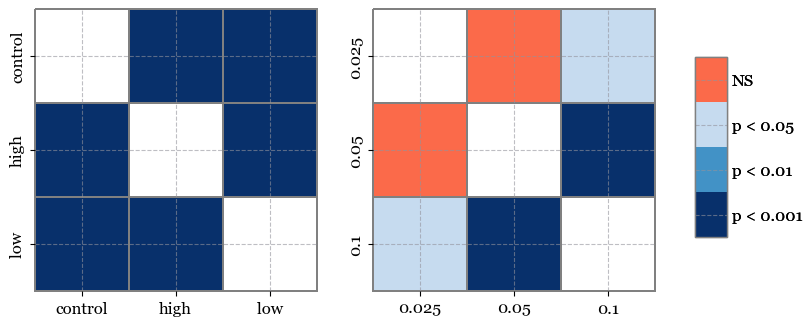

In [4]:
#Occluder size many small
df_many_small = df[(df['size_occl'] == "many small") & df['acc'] == True ]
#Rank transformation
df_many_small['rt'] = rankdata(df_many_small['rt'])

many_small_anova = pg.rm_anova(data= df_many_small, dv='rt', within=["difficulty", 'soa'], subject = "pt_num", detailed = True)
display(many_small_anova)

posthoc_soa = sp.posthoc_dunn(df_many_small, val_col= "rt", group_col= "difficulty", p_adjust='bonferroni')
display(posthoc_soa)

posthoc_size_occl = sp.posthoc_dunn(df_many_small, val_col= "rt", group_col= "soa", p_adjust='bonferroni')
display(posthoc_size_occl)

#PLotting them as signplots
fig, ax = plt.subplots(1,2,figsize=(8, 6))
cmap = ['1', '#fb6a4a',  '#08306b',  '#4292c6', '#c6dbef']
heatmap_args = {'cmap': cmap, 'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.95, 0.35, 0.04, 0.3]}
sp.sign_plot(posthoc_soa, **heatmap_args, ax =ax[0])

sp.sign_plot(posthoc_size_occl, **heatmap_args, ax= ax[1])

#Down below we do Tukey multiple comparisons

### Sub-Anova on few large checking for effects of difficulty X Soa

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,difficulty,6.728739e+07,2,56,3.364369e+07,56.316952,3.933759e-14,2.621493e-13,0.043960,0.930619
1,soa,1.504054e+06,2,56,7.520268e+05,1.763035,1.809101e-01,1.851492e-01,0.001027,0.890337
2,difficulty * soa,2.218613e+06,4,112,5.546533e+05,1.975656,1.030523e-01,1.276458e-01,0.001514,0.708671


,control,high,low
control,1.000000e+00,2.458410e-32,2.622182e-08
high,2.458410e-32,1.000000e+00,1.583753e-09
low,2.622182e-08,1.583753e-09,1.000000e+00


,0.025,0.050,0.100
0.025,1.000000,1.000000,0.270916
0.050,1.000000,1.000000,0.138887
0.100,0.270916,0.138887,1.000000


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x26887255a30>)

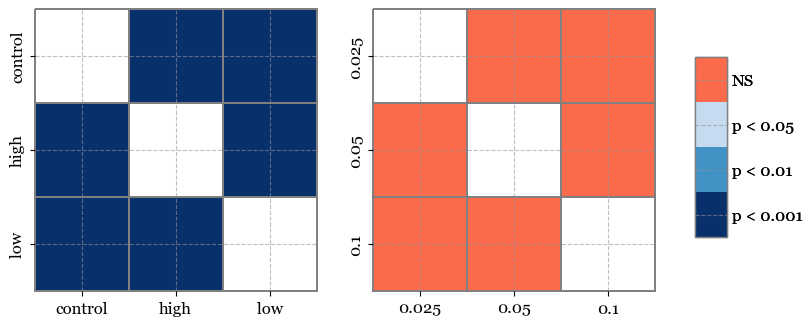

In [5]:
#Occluder size few large
df_few_large = df[(df['size_occl'] == "few large") & df['acc'] == True ]
#Rank Transformation
df_few_large['rt'] = rankdata(df_few_large['rt'])

many_small_anova = pg.rm_anova(data= df_few_large, dv='rt', within=["difficulty", 'soa'], subject = "pt_num", detailed = True)
display(many_small_anova)

posthoc_soa = sp.posthoc_dunn(df_few_large, val_col= "rt", group_col= "difficulty", p_adjust='bonferroni')
display(posthoc_soa)

posthoc_size_occl = sp.posthoc_dunn(df_few_large, val_col= "rt", group_col= "soa", p_adjust='bonferroni')
display(posthoc_size_occl)

#PLotting them as signplots
fig, ax = plt.subplots(1,2,figsize=(8, 6))
cmap = ['1', '#fb6a4a',  '#08306b',  '#4292c6', '#c6dbef']
heatmap_args = {'cmap': cmap, 'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.95, 0.35, 0.04, 0.3]}
sp.sign_plot(posthoc_soa, **heatmap_args, ax =ax[0])

sp.sign_plot(posthoc_size_occl, **heatmap_args, ax= ax[1])

#Down below we do Tukey multiple comparisons

# Conclusion

**It is shown that most of the effects in the un-transformed data is still present.** 

With an exception on few-large, main effect of SOA was significant in original analysis. But with rank-transformation this main effect of SOA is not present anymore. There are also some differences in multiple comparisons. 

(In the original script it was checked with Tukey's test but since it does not fit for non-parametric dataset, we have used Dunn's test which is the equivalent of Tukey's test but on non-parametric data.)